# Lab Five: Wide and Deep Networks

***Md Mahfuzur Rahman, Will Schneider, Nik Zelenikovski***



## 1. Preparation

In [212]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)

df = pd.read_csv('salaries.csv') # read in the csv file


print(df.info())
print('===========')
# note that the describe function defaults to using only some variables
print(df.describe())
print('===========')

print(df.select_dtypes(include=['object']).nunique().sum(),"unique class variables")
print('===========')

df = df.drop_duplicates()
df = df.dropna().reset_index(drop=True)
print(df.shape)

# create a data description table
data_des = pd.DataFrame()
#code adapted from sample Lab 1 Submission
data_des['Features'] = df.columns
data_des['Description'] = ['Work Year', 'Position Experience Level',
                          'Employment Type', 'Job Title',
                          'Position Salary', 'Currency of Salary',
                          'Position Salary (USD)', 'Employee Residence',
                          'Percentage of Job Responsibilities Completed Remotely', 'Company Location', 'Company Size']
data_des['Scales'] = ['interval'] + ['ordinal'] + ['nominal']*2 + ['ratio'] + ['nominal']+ ['ratio'] + ['nominal'] + ['ratio'] + ['nominal'] + ['ordinal']
data_des['Discrete\Continuous'] = ['continuous'] + ['discrete']*3 + ['continuous'] + \
                                  ['discrete'] + ['continuous'] + ['discrete'] + ['continuous'] + ['discrete']*2
data_des['Unique Values'] = df[df.columns].nunique().values
data_des

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23710 entries, 0 to 23709
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           23710 non-null  int64 
 1   experience_level    23710 non-null  object
 2   employment_type     23710 non-null  object
 3   job_title           23710 non-null  object
 4   salary              23710 non-null  int64 
 5   salary_currency     23710 non-null  object
 6   salary_in_usd       23710 non-null  int64 
 7   employee_residence  23710 non-null  object
 8   remote_ratio        23710 non-null  int64 
 9   company_location    23710 non-null  object
 10  company_size        23710 non-null  object
dtypes: int64(4), object(7)
memory usage: 2.0+ MB
None
          work_year        salary  salary_in_usd  remote_ratio
count  23710.000000  2.371000e+04   23710.000000  23710.000000
mean    2023.460565  1.618500e+05  151918.919823     27.954450
std        0.693803  2.

,Features,Description,Scales,Discrete\Continuous,Unique Values
0,work_year,Work Year,interval,continuous,5
1,experience_level,Position Experience Level,ordinal,discrete,4
2,employment_type,Employment Type,nominal,discrete,4
3,job_title,Job Title,nominal,discrete,169
4,salary,Position Salary,ratio,continuous,3400
5,salary_currency,Currency of Salary,nominal,discrete,24
6,salary_in_usd,Position Salary (USD),ratio,continuous,3804
7,employee_residence,Employee Residence,nominal,discrete,89
8,remote_ratio,Percentage of Job Responsibilities Completed R...,ratio,continuous,3
9,company_location,Company Location,nominal,discrete,78


### 1.1 Class Variable Definition and Dataset Preparation for Classification/Regression

Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). You have the option of using tf.dataset for processing, but it is not required.

#### Class Variables
This dataset has 8 features with class variables. Three of the features have n > 20 unique classes, which will be reduced through embedding later in this notebook. 'remote_ratio' is a numeric feature with three values in the dataset indicating the percentage of remote work. The available values are 0, 50, 100. The data source considers these values labeled (0: Non-Remote, Hybrid, & Fully Remote. These will be converted to categorical features in the code below. A  description of all the datatypes is in the code output below. In total, the 371 unique classes exist within categorical features. These will need to be processed for dimensionality reduction and embedding into the model. Additionally, two of the categorical features resemble ordinality, even expressed in the name of the features 'company_**size**' & 'experience_**level**'. They also have low cardinality. These will be converted to labeled variables and they will be crossed with other categorical columns later in this notebook.

#### Classification splitting

In [213]:
#==================================================================
from sklearn import __version__ as sklearn_version
if sklearn_version < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.model_selection import StratifiedShuffleSplit

# Label encoding for categorical variables
le = LabelEncoder()
X_train.loc[:,'remote_ratio'] = le.fit_transform(X_train['remote_ratio'])
X_test.loc[:,'remote_ratio'] = le.transform(X_test['remote_ratio'])

# Encode ordinal features
exp_mapping = {'EN': 0, 'MI': 1, 'SE': 2, 'EX': 3}
size_mapping = {'S': 0, 'M': 1, 'L': 2}

# Apply the mappings to the entire dataset
df['experience_level'] = df['experience_level'].map(exp_mapping)
df['company_size'] = df['company_size'].map(size_mapping)

# Ensure the numeric headers are float
# define variables that should be scaled or made discrete
numeric_headers = ['work_year', 'remote_ratio','salary', 'salary_in_usd']
# df[numeric_headers] = df[numeric_headers].to_numpy().astype(float)

#FILTER LESS FREQUENT JOBS (FOR TARGET VARIABLE ENGINEERING)
# Count occurrences of each job title (this helps with straified splitting)
job_title_counts = df['job_title'].value_counts()
# Filter out job titles with less than 4 occurrences (Removes 19 jobs, but will calculate a median actually to predict on)
# And it prevents freebies to the model! because if it's unseen, as far as the model is concerned, that value is the median.
valid_job_titles = job_title_counts[job_title_counts >= 4].index
df = df[df['job_title'].isin(valid_job_titles)].copy()


# Initial split to separate a test set
X = df.drop(columns=['salary', 'salary_in_usd'])
y = df['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine the full training data for further splits
training = deepcopy(pd.concat([X_train, y_train], axis=1))
testing = deepcopy(pd.concat([X_test, y_test], axis=1))

# Drop any missing values
training.dropna(inplace=True)
training.reset_index(inplace=True, drop=True)
testing.dropna(inplace=True)
testing.reset_index(inplace=True, drop=True)

# Step 2: Calculate the median salary by company size in the training set
median_salary_by_job_title = training.groupby('job_title')['salary_in_usd'].median()

# Step 3: Create binary target variable based on whether salary is above or below the median for the company size
training['salary_binary'] = training.apply(
    lambda row: 1 if row['salary_in_usd'] > median_salary_by_job_title[row['job_title']]
    else 0, axis=1
)

# Create binary target variable for the test set
testing['salary_binary'] = testing.apply(
    lambda row: 1 if row['job_title'] in median_salary_by_job_title
    and row['salary_in_usd'] > median_salary_by_job_title[row['job_title']]
    else 0, axis=1
)

# Separate features and target for further splitting
X_train = training.drop(columns=[ 'salary_in_usd', 'salary_binary'])
y_train = training['salary_binary']
X_test = testing.drop(columns=[ 'salary_in_usd', 'salary_binary'])
y_test= testing['salary_binary']

# Use StratifiedShuffleSplit to ensure balanced class distribution
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)


#### Pre-Processing with TensorFlow

##### Ordinal Variables & Target-Variable Normalization

In [214]:
# ========================================================
# define variables that should be encoded as integers
categorical_headers = ['company_location','employee_residence',
                       'employment_type','job_title','salary_currency','experience_level','company_size','remote_ratio']
numeric_headers = ['work_year']
# get unique values in each feature
for col in categorical_headers:
    print(f'{col} has {len(X_train[col].unique())} unique values.')
print("\n===================\n")

#get the number of unique values per column
cols_of_interest = ['company_size','company_location', 'employee_residence','experience_level',
                    'employment_type','job_title','salary_currency','remote_ratio']
unique_counts = df[cols_of_interest].nunique()

print(unique_counts,"\n")

company_location has 69 unique values.
employee_residence has 77 unique values.
employment_type has 4 unique values.
job_title has 110 unique values.
salary_currency has 20 unique values.
experience_level has 4 unique values.
company_size has 3 unique values.
remote_ratio has 3 unique values.


company_size            3
company_location       76
employee_residence     87
experience_level        4
employment_type         4
job_title             110
salary_currency        22
remote_ratio            3
dtype: int64 



##### Create a TF Dataset

In [215]:
# !python.exe -m pip install --upgrade pip
# !pip install --upgrade tensorflow
# !pip install --upgrade keras
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn import metrics as mt
import tensorflow as tf
from tensorflow import keras
import sys

print(tf.__version__)
print(keras.__version__)
print(sys.version)

from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# create a tensorflow dataset, for ease of use later
batch_size = 64

def create_dataset_from_dataframe(df_input,label):

    df = df_input.copy()
    labels = df.pop(label)
    # labels = df['salary_binary']
    print("no_error1")
    df = {key: value.values[:,np.newaxis] for key, value in df_input[categorical_headers+numeric_headers].items()}
    print("no_error2")
    # create the Dataset here
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    print("no_error3")
    # now enable batching and prefetching
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    print("no_error4")

    return ds


# Model creation function
def create_model(input_dim):
    inputs = {col: Input(shape=(1,), name=col) for col in X_train.columns}
    concatenated = Concatenate()(list(inputs.values()))
    x = Dense(64, activation='relu')(concatenated)
    x = Dense(32, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

ds_train = create_dataset_from_dataframe(training.drop('salary_in_usd',axis=1),'salary_binary')
ds_test = create_dataset_from_dataframe(testing.drop('salary_in_usd',axis=1),'salary_binary')


2.16.1
3.4.1
3.9.19 (main, May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)]
no_error1
no_error2
no_error3
no_error4
no_error1
no_error2
no_error3
no_error4


### 1.2 Crossed Features
#### 1 Employee Residence x Remote Ratio
- How is the salary in USD influenced by the employee's type of salary paid? This is probably a strong indicator of pay based on area. If the pay is not in USD, it might be more of a comtract role
- Total = 9 X 4 = 36
#### 2 Company Location x Company Size
- Companies in the US will probably be larger as it is the leading big tech country.
- Total = 9 * 3 = 27
#### 3 Job Title x Experience Level
- Specifics about each position (such as "Data Science Lead") suggest the experience/authority level
- Total = 13 * 4 = 52

In [216]:
from tensorflow.keras.utils import FeatureSpace

# Crossing columns together
feature_space1 = FeatureSpace(
    features={
        # Categorical feature encoded as string
        # "experience_level": FeatureSpace.string_categorical(num_oov_indices=0),
        "employment_type": FeatureSpace.string_categorical(num_oov_indices=0,),
        "job_title": FeatureSpace.string_categorical(num_oov_indices=0),
        "salary_currency": FeatureSpace.string_categorical(num_oov_indices=1),
        "employee_residence": FeatureSpace.string_categorical(num_oov_indices=1),
        "company_location": FeatureSpace.string_categorical(num_oov_indices=1),

        # Categorical feature encoded as integers
        
        "company_size": FeatureSpace.integer_categorical(num_oov_indices=0),
        "experience_level": FeatureSpace.integer_categorical(num_oov_indices=0),
        "remote_ratio": FeatureSpace.integer_categorical(num_oov_indices=0),

        # Numerical features to normalize (normalization will be learned)
        # learns the mean, variance, and if to invert (3 parameters)
        # "salary_in_usd": FeatureSpace.float_normalized(),
        "work_year": FeatureSpace.float_normalized()

            },
    # Specify feature cross with a custom crossing dim
    crosses=[
        FeatureSpace.cross(
            feature_names=('employment_type','company_size'), # 8 x 3 = 24
            crossing_dim=4*3),
        FeatureSpace.cross(
            feature_names=('job_title','experience_level'), # 12 x 4 = 48
            crossing_dim=12*4),
    ],
    output_mode="concat",
)

# create a version of the dataset that can be iterated without labels
train_ds_with_no_labels = ds_train.map(lambda x, _: x)
feature_space1.adapt(train_ds_with_no_labels) # inititalize the feature map to this data

# the adapt function allows the model to learn one-hot encoding sizes
# now define a preprocessing operation that returns the processed features
preproc_ds_train = ds_train.map(lambda x, y: (feature_space1(x), y),
                                     num_parallel_calls=tf.data.AUTOTUNE)
# run it so that we can use the pre-processed data
preproc_ds_train = preproc_ds_train.prefetch(tf.data.AUTOTUNE)

# do the same for the test set
preproc_ds_test = ds_test.map(lambda x, y: (feature_space1(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preproc_ds_test = preproc_ds_test.prefetch(tf.data.AUTOTUNE)

#### Dimensionality Reduction (Square Root Heuristic)

In TensorFlow, embeddings are used to convert categorical data into continuous vector spaces, where similar categories are mapped closer together. The embedding layer in TensorFlow is a trainable layer that learns a fixed-size continuous vector representation for each category. This is especially useful for high cardinality categorical features. By choosing to embed certain classes with high cardinality, we reduced the dimensionality of the dataset. This was particularly useful in Keras, as the only real requirement is to encode the data one-hot.

In [217]:
from tensorflow.keras.layers import Embedding, Flatten

def setup_embedding_from_categorical(feature_space, col_name):
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    N = len(feature_space.preprocessors[col_name].get_vocabulary())

    # get the output from the feature space, which is input to embedding
    x = feature_space.preprocessors[col_name].output

    # now use an embedding to deal with integers from feature space
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col_name+'_embed')(x)

    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)

    return x # return the tensor here

# # # add explanation of this pre-processing here
train_ds_with_no_labels = ds_train.map(lambda x, _: x)
# feature_space1.adapt(train_ds_with_no_labels)

def setup_embedding_from_crossing(feature_space, col_name):
    # what the maximum integer value for this variable?

    # get the size of the feature
    N = feature_space.crossers[col_name].num_bins
    x = feature_space.crossers[col_name].output


    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col_name+'_embed')(x)

    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)

    return x

From the raw data, the model has almost 25,000 parameters! That is a lot of parameters and could lead to longer computation times. To reduce dimensionality, we then passed into the TensorFlow model, and the gradient of the distances/connections of these feature-specific classes is solved, returning an output of a specified reduced size ($\sqrt{n}$) that still maintains the majority of the information from the original data. These approximations are the output of the feature space in the below code.

##### *'salary_currenecy'*
- - **Number of dimensions after reduction = $\sqrt{24} \approx 4$**
##### *'company_location'*
- - **Number of dimensions after reduction = $\sqrt{78} \approx 8$**
##### *'employee_residence'*
- **Number of dimensions after reduction = $\sqrt{89} \approx 9$**
##### *'job_title'*
- **Number of dimensions after reduction = $\sqrt{169} \approx 12$**

## 2. Modeling: Define the Wide and Deep Network Models

We will use Keras to develop three alternative broad and deep networks to categorize wage data. Each network will have a unique design to investigate how different combinations of broad and deep components impact the model's performance.

### Model 1: Basic Wide and Deep Network

This model has a wide component (a basic linear layer) and a deep component (three hidden layers).

In [218]:
# import the loss function we plan to use
from tensorflow.keras.losses import binary_crossentropy
# import a built in optimizer
# I am using legacy for an M1 chipset speed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Concatenate
from matplotlib import pyplot as plt

def create_model1(feature_space):
    

    dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output
    encoded_features = feature_space.get_encoded_features()
    # we need to create separate lists for each branch
    crossed_outputs = []

    # for each crossed variable, make an embedding
    for col in feature_space.crossers.keys():
        x = setup_embedding_from_crossing(feature_space, col)

        # save these outputs in list to concatenate later
        crossed_outputs.append(x)

    # now concatenate the outputs and add a fully connected layer
    wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

    # reset this input branch
    all_deep_branch_outputs = []

    # for each numeric variable, just add it in after embedding
    for idx,col in enumerate(['work_year','remote_ratio']):
        x = feature_space.preprocessors[col].output
        # x = tf.cast(132,float) # cast an integer as a float here
        all_deep_branch_outputs.append(x)

    # for each categorical variable
    for col in categorical_headers:

        # get the output tensor from ebedding layer
        x = setup_embedding_from_categorical(feature_space, col)
        # save these outputs in list to concatenate later
        all_deep_branch_outputs.append(x)


    # Define deep branch with numeric and categorical features
    deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)
    deep_branch = Dense(units=32,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=16,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=8,activation='relu', name='deep3')(deep_branch)

    # merge the deep and wide branch
    final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch])
    final_branch = Dense(units=1,activation='sigmoid',
                         name='combined')(final_branch)
    
    training_model = keras.Model(inputs=dict_inputs, outputs=final_branch)
    training_model.compile(
        optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    model = tf.keras.Model(inputs=dict_inputs, outputs=final_branch)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

C:\Users\wschneider\anaconda3\envs\cs7324_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_66"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ remote_ratio        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ company_location    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ employee_residence  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ employment_type     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ job_title           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ salary_currency     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ experience_level    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ company_size        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ integer_categorica… │ (None, 1)         │          0 │ remote_ratio[0][… │
│ (IntegerLookup)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ company_location… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ employee_residen… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ employment_type[… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ job_title[0][0]   │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ salary_currency[… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ integer_categorica… │ (None, 1)         │          0 │ experience_level… │
│ (IntegerLookup)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ integer_categorica… │ (None, 1)         │          0 │ company_size[0][… │
│ (IntegerLookup)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ work_year           │ (None, 1)         │          0 │ -               

 Total params: 4,647 (18.16 KB)

 Trainable params: 4,644 (18.14 KB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/50
167/167 - 2s - 14ms/step - accuracy: 0.5930 - loss: 0.6677 - val_accuracy: 0.6440 - val_loss: 0.6314
Epoch 2/50
167/167 - 0s - 2ms/step - accuracy: 0.6336 - loss: 0.6301 - val_accuracy: 0.6519 - val_loss: 0.6172
Epoch 3/50
167/167 - 0s - 2ms/step - accuracy: 0.6393 - loss: 0.6221 - val_accuracy: 0.6515 - val_loss: 0.6128
Epoch 4/50
167/167 - 0s - 2ms/step - accuracy: 0.6432 - loss: 0.6179 - val_accuracy: 0.6512 - val_loss: 0.6101
Epoch 5/50
167/167 - 0s - 3ms/step - accuracy: 0.6425 - loss: 0.6149 - val_accuracy: 0.6519 - val_loss: 0.6085
Epoch 6/50
167/167 - 0s - 2ms/step - accuracy: 0.6411 - loss: 0.6124 - val_accuracy: 0.6515 - val_loss: 0.6077
Epoch 7/50
167/167 - 0s - 2ms/step - accuracy: 0.6434 - loss: 0.6102 - val_accuracy: 0.6489 - val_loss: 0.6069
Epoch 8/50
167/167 - 0s - 2ms/step - accuracy: 0.6433 - loss: 0.6082 - val_accuracy: 0.6512 - val_loss: 0.6067
Epoch 9/50
167/167 - 0s - 2ms/step - accuracy: 0.6448 - loss: 0.6064 - val_accuracy: 0.6508 - val_loss: 0.6066


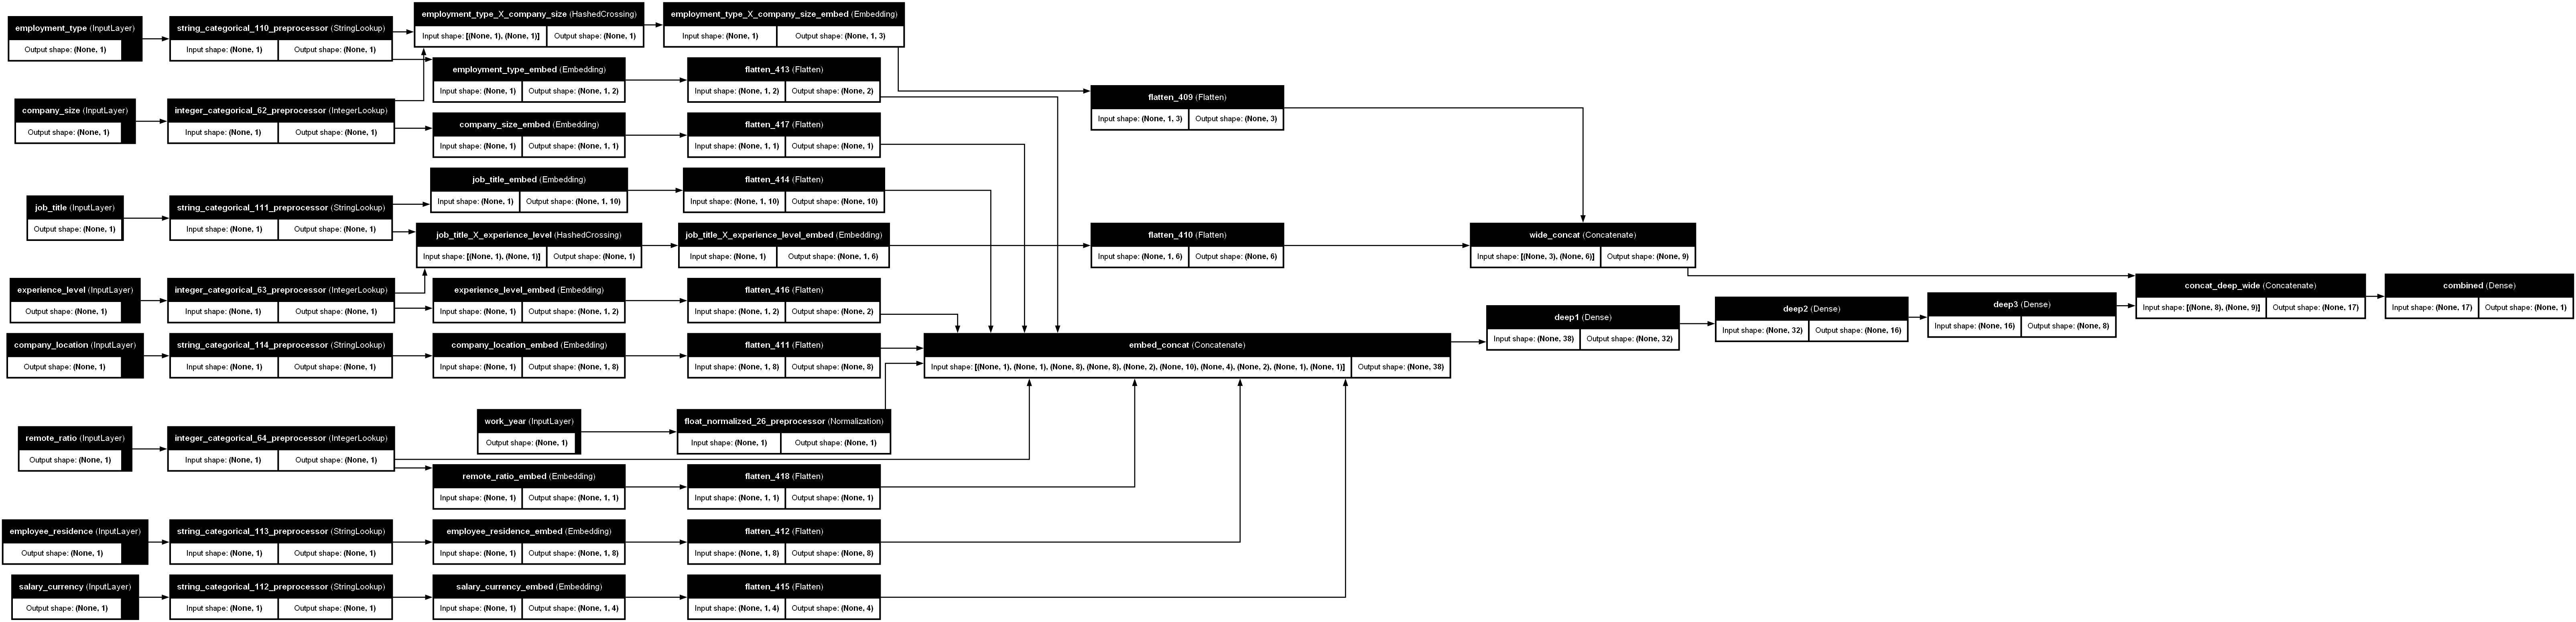

In [219]:
model1 = create_model1(feature_space1)
model1.summary()

# train using the already processed features
history1 = model1.fit(
    ds_train  , validation_data=ds_test , epochs=50, batch_size=32, verbose=2)

plot_model(
    model1, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

We have selected Mean Squared Error (MSE) and Mean Absolute Error (MAE) as the best accuracy metrics to evaluate our algorithm's performance. We recognize your expertise as data scientists, machine learning engineers, and technical stakeholders, and believe that MSE and MAE offer a balanced assessment of our regression model, ensuring accurate and consistent predictions. Considering our dataset's characteristics, these metrics provide a better performance measure than relying on a single metric alone.

MSE balances the model’s precision by penalizing more significant errors, ensuring that the model minimizes substantial deviations from the actual values. This is vital for capturing the accuracy of our predictions. On the other hand, MAE offers a robust measure that treats all errors equally, providing an intuitive understanding of the model's overall prediction accuracy.

Pre-processing steps, such as scaling and encoding, are crucial for accurately calculating MSE and MAE, leading to highly reliable evaluation metrics. The selected MSE and MAE will guide the evaluation of our wide and deep networks, ensuring a balanced assessment. Effective cross-product features also enhance model performance, as reflected by these metrics.

In conclusion, MSE and MAE are the most appropriate metrics for our project as they balance the penalization of more significant errors and provide a robust, interpretable assessment of our model's performance in real-world scenarios.arios.

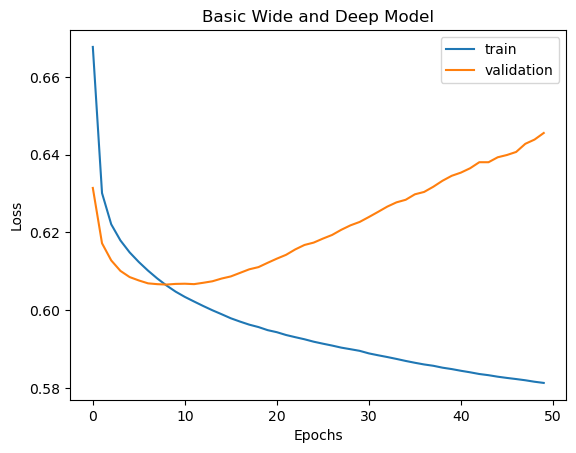

In [220]:
def plot_history(history, title):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history1, 'Basic Wide and Deep Model')

### Model 2: Deep Network with More Layers

This model expands the depth of the deep component to investigate how a deeper network impacts performance.

In [208]:
def create_model2(feature_space):
    dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output
    encoded_features = feature_space.get_encoded_features()
    # we need to create separate lists for each branch
    crossed_outputs = []

    # for each crossed variable, make an embedding
    for col in feature_space.crossers.keys():
        x = setup_embedding_from_crossing(feature_space, col)

        # save these outputs in list to concatenate later
        crossed_outputs.append(x)

    # now concatenate the outputs and add a fully connected layer
    wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

    # reset this input branch
    all_deep_branch_outputs = []

    # for each numeric variable, just add it in after embedding
    for idx,col in enumerate(numeric_headers):
        x = feature_space.preprocessors[col].output
        # x = tf.cast(132,float) # cast an integer as a float here
        all_deep_branch_outputs.append(x)

    # for each categorical variable
    for col in categorical_headers:

        # get the output tensor from ebedding layer
        x = setup_embedding_from_categorical(feature_space, col)
        # save these outputs in list to concatenate later
        all_deep_branch_outputs.append(x)

    # Define deep branch with numeric and categorical features
    deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)
    deep_branch = Dense(units=256,activation='relu', name='deep1')(deep_branch)
    deep_branch = Dense(units=128,activation='relu', name='deep2')(deep_branch)
    deep_branch = Dense(units=64,activation='relu', name='deep3')(deep_branch)
   

    # merge the deep and wide branch
    final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch])
    final_branch = Dense(units=1,activation='sigmoid',
                         name='combined')(final_branch)
    
    training_model = keras.Model(inputs=dict_inputs, outputs=final_branch)
    training_model.compile(
        optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    model = tf.keras.Model(inputs=dict_inputs, outputs=final_branch)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

Model: "functional_64"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ company_location    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ employee_residence  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ employment_type     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ job_title           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ salary_currency     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ experience_level    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ company_size        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ remote_ratio        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ company_location… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ employee_residen… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ employment_type[… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ job_title[0][0]   │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ salary_currency[… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ integer_categorica… │ (None, 1)         │          0 │ experience_level… │
│ (IntegerLookup)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ integer_categorica… │ (None, 1)         │          0 │ company_size[0][… │
│ (IntegerLookup)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ integer_categorica… │ (None, 1)         │          0 │ remote_ratio[0][… │
│ (IntegerLookup)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ work_year           │ (None, 1)         │          0 │ -               

 Total params: 55,341 (216.18 KB)

 Trainable params: 55,338 (216.16 KB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/50
168/168 - 2s - 14ms/step - accuracy: 0.6028 - loss: 0.6488 - val_accuracy: 0.6438 - val_loss: 0.6409
Epoch 2/50
168/168 - 0s - 2ms/step - accuracy: 0.6369 - loss: 0.6223 - val_accuracy: 0.6513 - val_loss: 0.6243
Epoch 3/50
168/168 - 0s - 2ms/step - accuracy: 0.6420 - loss: 0.6152 - val_accuracy: 0.6490 - val_loss: 0.6193
Epoch 4/50
168/168 - 0s - 2ms/step - accuracy: 0.6439 - loss: 0.6103 - val_accuracy: 0.6487 - val_loss: 0.6175
Epoch 5/50
168/168 - 0s - 2ms/step - accuracy: 0.6451 - loss: 0.6065 - val_accuracy: 0.6479 - val_loss: 0.6183
Epoch 6/50
168/168 - 0s - 2ms/step - accuracy: 0.6464 - loss: 0.6033 - val_accuracy: 0.6472 - val_loss: 0.6206
Epoch 7/50
168/168 - 0s - 3ms/step - accuracy: 0.6483 - loss: 0.6007 - val_accuracy: 0.6461 - val_loss: 0.6228
Epoch 8/50
168/168 - 0s - 3ms/step - accuracy: 0.6491 - loss: 0.5986 - val_accuracy: 0.6472 - val_loss: 0.6250
Epoch 9/50
168/168 - 0s - 2ms/step - accuracy: 0.6500 - loss: 0.5968 - val_accuracy: 0.6457 - val_loss: 0.6264


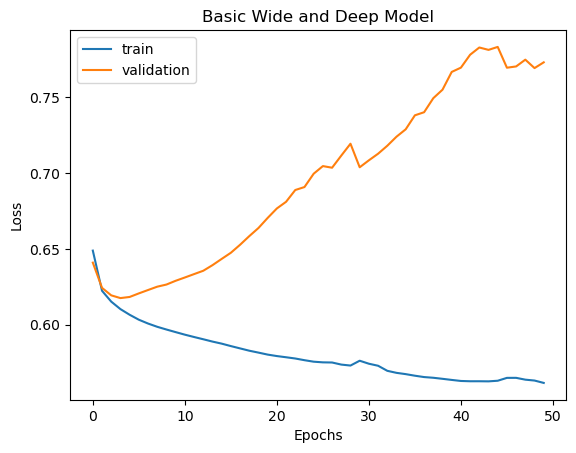

In [209]:
model2 = create_model2(feature_space1)
model2.summary()

# train using the already processed features
history2 = model2.fit(
    ds_train  , validation_data=ds_test , epochs=50, batch_size=32, verbose=2)

def plot_history(history, title):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history2, 'Basic Wide and Deep Model')


In [210]:
#!pip install pydot
#!pip install graphviz
# these are the placeholder inputs in the computation graph BEFORE
# applying and transformations
dict_inputs = feature_space1.get_inputs()  #getting inputs is WAY easier now

# these are the encoded features after they have been processed
# We can use these as additional inpits into the computation graph
encoded_features = feature_space.get_encoded_features() # these features have been encoded

# using feature space above, this will result in 131 concatenated features
# this is calucalted based on the one-hot encodings for each category

# now lets create some layers with Keras
x = keras.layers.Dense(64, activation="relu")(encoded_features)
x = keras.layers.Dense(32, activation="relu")(x)
predictions = keras.layers.Dense(1, activation="sigmoid")(x)

# we can now create two input/outputs to the computation graph

# this expects features already transformed
training_model = keras.Model(inputs=encoded_features,
                             outputs=predictions)
training_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

# this expects features that are not transformed
inference_model = keras.Model(inputs=dict_inputs,
                              outputs=predictions)
inference_model.compile(loss="binary_crossentropy", metrics=["accuracy"])

inference_model.summary()

# plot_model(
#     training_model, to_file='model.png', show_shapes=True, show_layer_names=True,
#     rankdir='LR', expand_nested=False, dpi=96
# )

NameError: name 'feature_space' is not defined

### 1.2 Crossed Features
#### 1 Employee Residence x Remote Ratio
- How is the salary in USD influenced by the employee's type of salary paid? This is probably a strong indicator of pay based on area. If the pay is not in USD, it might be more of a comtract role
- Total = 9 X 4 = 36
#### 2 Company Location x Company Size
- Companies in the US will probably be larger as it is the leading big tech country.
- Total = 9 * 3 = 27
#### 3 Job Title x Experience Level
- Specifics about each position (such as "Data Science Lead") suggest the experience/authority level
- Total = 13 * 4 = 52

In [ ]:
from tensorflow.keras.utils import FeatureSpace

# Crossing columns together
feature_space = FeatureSpace(
    features={
        # Categorical feature encoded as string
        # "experience_level": FeatureSpace.string_categorical(num_oov_indices=0),
        "employment_type": FeatureSpace.string_categorical(num_oov_indices=0,),
        "job_title": FeatureSpace.string_categorical(num_oov_indices=0),
        "salary_currency": FeatureSpace.string_categorical(num_oov_indices=0),
        "employee_residence": FeatureSpace.string_categorical(num_oov_indices=0),
        "company_location": FeatureSpace.string_categorical(num_oov_indices=0),

        # Categorical feature encoded as integers
        "remote_ratio": FeatureSpace.integer_categorical(num_oov_indices=0),
        "company_size": FeatureSpace.integer_categorical(num_oov_indices=0),
        "experience_level": FeatureSpace.integer_categorical(num_oov_indices=0),


        # Numerical features to normalize (normalization will be learned)
        # learns the mean, variance, and if to invert (3 parameters)
        # "salary_in_usd": FeatureSpace.float_normalized(),

        "work_year": FeatureSpace.float_normalized(),
            },
    # Specify feature cross with a custom crossing dim
    crosses=[
        FeatureSpace.cross(
            feature_names=('employee_residence','employment_type'), # dims: 9 x 3 x 4 = 108
            crossing_dim=9*3*4),
        FeatureSpace.cross(
            feature_names=('company_location','company_size'), # 8 x 3 = 24
            crossing_dim=8*3),
        FeatureSpace.cross(
            feature_names=('job_title','experience_level'), # 12 x 4 = 48
            crossing_dim=12*4),
    ],
    output_mode="concat",
)
# workclass has 7 unique values.
# education has 16 unique values.
# marital_status has 7 unique values.
# occupation has 14 unique values.
# relationship has 6 unique values.
# race has 5 unique values.
# sex has 2 unique values.
# country has 41 unique values.

# add explanation of this pre-processing here
train_ds_with_no_labels = ds_train.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

def setup_embedding_from_crossing(feature_space, col_name):
    # what the maximum integer value for this variable?

    # get the size of the feature
    N = feature_space.crossers[col_name].num_bins
    x = feature_space.crossers[col_name].output


    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col_name+'_embed')(x)

    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)

    return x

Thanks to dimensionality reduction, we reduced the number of parameters by about 7-fold. This reduction leaves us room to cross some of these features to build stronger connections in the model.

In [ ]:
dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output

# we need to create separate lists for each branch
crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():

    x = setup_embedding_from_crossing(feature_space, col)

    # save these outputs in list to concatenate later
    crossed_outputs.append(x)


# now concatenate the outputs and add a fully connected layer
wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

# reset this input branch
all_deep_branch_outputs = []

# for each numeric variable, just add it in after embedding
for idx,col in enumerate(numeric_headers):
    x = feature_space.preprocessors[col].output
    # x = tf.cast(132,float) # cast an integer as a float here
    all_deep_branch_outputs.append(x)

# for each categorical variable
for col in categorical_headers:

    # get the output tensor from ebedding layer
    x = setup_embedding_from_categorical(feature_space, col)

    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)


# merge the deep branches together
deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)

# merge the deep and wide branch
final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch])
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

training_model = keras.Model(inputs=dict_inputs, outputs=final_branch)
training_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

training_model.summary()

plot_model(
    training_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

### 1.3 Evaluation Metrics

##### Classification
What are the implications of misclassifications?

##### Regression

Stratified Shuffle Split:

Use when you have an imbalanced dataset and want to combine the benefits of random shuffling with maintaining class distribution.
Suitable for ensuring that each split is representative and for avoiding overfitting.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in sss.split(X, y):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]